Code for the ranking of models using the PNR dataset.
Different ranges of data (both magnitude and epicentral distrance) are included in this.
Four different models are considered for ranking - Edwards et al, 2021, Atkinson et al, 2015, Douglas et al, 2013 and Rietbroke et al 2013.
The tests considered for ranking are LLH test, Chi square misfit test and Area Metric.

In [78]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import csv
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from re import compile, match
import areametric_easy as am
from matplotlib.ticker import ScalarFormatter

In [79]:
#reading a csv file as pandas dataframe
#col_list = ["comp","ID","stn","magnitude","mag_type","Mw","depth","hypodist","fmin","fmax","site","obs","pred","res"]
df = pd.read_csv("/Users/jaleenasunny/code_notebook/Data_Masking/data_Masking_data/pnr_new.csv",sep=',')
df_new_1 = df.dropna()
df_new_1

hypoR_0 = df_new_1["Rhyp (km)"] <= 10
hypoR_10 = df_new_1["Rhyp (km)"] > 10

hypoR_0_1 = (df_new_1["Rhyp (km)"] <= 10) &  (df_new_1['M'] < 1)
hypoR_10_1 = (df_new_1["Rhyp (km)"] > 10) & (df_new_1['M'] < 1)

hypoR_0_2 = (df_new_1["Rhyp (km)"] <= 10) & (df_new_1['M'] >= 1) & (df_new_1['M'] <= 2)
hypoR_10_2 = (df_new_1["Rhyp (km)"] > 10) & (df_new_1['M'] >= 1) & (df_new_1['M'] <= 2)
                                           
hypoR_0_4 = (df_new_1["Rhyp (km)"] <= 10) & (df_new_1['M'] > 2) & (df_new_1['M'] <= 4)
hypoR_10_4 = (df_new_1["Rhyp (km)"] > 10) & (df_new_1['M'] > 2) & (df_new_1['M'] <= 4)
                                           
df_0 = df_new_1[hypoR_0]
df_10 = df_new_1[hypoR_10]
df_0_1 = df_new_1[hypoR_0_1]
df_10_1 = df_new_1[hypoR_10_1]
df_0_2 = df_new_1[hypoR_0_2]
df_10_2 = df_new_1[hypoR_10_2]                                           
df_0_4 = df_new_1[hypoR_0_4]
df_10_4 = df_new_1[hypoR_10_4]

In [80]:
#Atkinson et al, 2015 is A2015
#A2015 GMPE defined by GMM_A. The outputs are the median prediction, observed data, model prediction with sigma and the model sigma. 
def GMM_A(df_new):
    c0 = -2.376
    c1 = 1.818
    c2 = -0.1153
    c3 = -1.752
    clin = -0.6
    Y = []
    hypoR = df_new['Rhyp (km)']
    PGA_obs = df_new['PGA']
    ID = df_new['ID']
    station = df_new['STN']
    mag_L = df_new['ML']
    M = df_new["M"]
    PGA_cm = [i*100 for i in PGA_obs]
    PGA_10 = [math.log10(i) for i in PGA_cm]
    M_2 = [i**2 for i in M]
    vs30 = df_new["Vs30"]
    M = M.tolist()
    mag_L = mag_L.tolist()
    hypoR = hypoR.tolist()
    ID = ID.tolist()
    station = station.tolist()
    vs30 = vs30.tolist()
    
    heff = []
    for i in range(len(M)):
        h1 = (0.19*M[i])-0.28
        h2 = max(1,h1)
        heff.append(h2)
    R = []
    for i in range(len(hypoR)):
        R.append(math.sqrt((hypoR[i]**2) + (heff[i]**2)))
    
    for i in range(len(M)):
        y1 = c1 * M[i]
        y2 = c2 * M[i]*M[i]
        y3 = c3 * (math.log10(R[i]))
        y4 = clin *math.log(min(vs30[i],1500)/760)/math.log(10)
        Y.append(c0 + y1 + y2 + y3 + y4)
    res = [a-b for a,b in zip(PGA_10,Y)]

    Y_sigma = []
    s = 0.37
    np.random.seed(1)
    z = np.random.normal(0,s,1000)
    for i in range(len(Y)):
        for j in range(len(z)):
            Y_sigma.append(Y[i] + z[j])
        

    return Y, PGA_10, Y_sigma, s


In [81]:
#Edwards et al 2021 is the B2021.
#B2021 GMPE defined by GMM_B. The outputs are the median prediction, observed data, model prediction with sigma and the model sigma. 

def GMM_B(df_new):
    c0 = -1.615
    c1 = 1.7605
    c2 = -0.1070
    c3 = -2.2639
    clin = -0.6
    Y = []
    hypoR = df_new['Rhyp (km)']
    PGA_obs = df_new['PGA']
    ID = df_new['ID']
    station = df_new['STN']
    mag_L = df_new['ML']
    M = df_new["M"]
    PGA_cm = [i*100 for i in PGA_obs]
    PGA_10 = [math.log10(i) for i in PGA_cm]
    M_2 = [i**2 for i in M]
    vs30 = df_new["Vs30"]
    M = M.tolist()
    mag_L = mag_L.tolist()
    hypoR = hypoR.tolist()
    ID = ID.tolist()
    station = station.tolist()
    vs30 = vs30.tolist()
    
    heff = []

    for i in range(len(M)):
        h1 = (-0.28 + (0.19*M[i])) #-1.72+0.43
        h2 = max(1,h1)
        heff.append(h2)
    R = []
    for i in range(len(hypoR)):
        R.append(math.sqrt((hypoR[i]**2) + (heff[i]**2)))
    for i in range(len(M)):
        y1 = c1 * M[i]
        y2 = c2 * (M[i]*M[i])
        y3 = c3 * (np.log10(R[i]))
        y4 = clin *math.log(min(vs30[i],1500)/760)/math.log(10)
        g = c0 + y1 + y2 + y3 + y4
        Y.append(g)
    res = [a-b for a,b in zip(PGA_10,Y)]
    
    Y_sigma = []
    s = 0.325
    np.random.seed(1)
    z = np.random.normal(0,s,1000)
    for i in range(len(Y)):
        for j in range(len(z)):
            Y_sigma.append(Y[i] + z[j])
        
    
    return Y, PGA_10, Y_sigma, s


In [1]:
#Douglas et al, 2013 is the D2013.
#D2013 GMPE defined by GMM_D. The outputs are the median prediction, observed data, model prediction with sigma and the model sigma. 

def GMM_D(df_new):
    h = 2.511
    a = -5.984
    b = 2.146
    c = -1.772
    d = -0.023
    clin = -0.6
    Y = []
    hypoR = df_new['Rhyp (km)']
    PGA_obs = df_new['PGA']
    ID = df_new['ID']
    station = df_new['STN']
    mag_L = df_new['ML']
    M = df_new["M"]
    PGA_cm = [i*100 for i in PGA_obs]
    PGA_10 = [math.log10(i) for i in PGA_cm]
    M_2 = [i**2 for i in M]
    vs30 = df_new["Vs30"]
    M = M.tolist()
    mag_L = mag_L.tolist()
    hypoR = hypoR.tolist()
    ID = ID.tolist()
    station = station.tolist()
    vs30 = vs30.tolist()
    

    R = []
    for i in range(len(hypoR)):
        R.append(math.sqrt((hypoR[i]**2) + (h**2)))
    
    Y_ln = []
    for i in range(len(M)):
        y1 = b * M[i]
        y2 = c * (math.log(R[i]))
        y3 = d * hypoR[i]
        y4 = clin *math.log(min(vs30[i],1500)/540)#/math.log(10)
        Y_ln.append(a + y1 + y2 + y3 + y4)
    Y_linear = [2.718**(i) for i in Y_ln]
    Y_cm = [i*100 for i in Y_linear]
    Y = [math.log10(i) for i in Y_cm]
    res = [a-b for a,b in zip(PGA_10,Y)]
    Y_sigma = []
    s = 0.498
    np.random.seed(1)
    z = np.random.normal(0,s,1000)
    for i in range(len(Y)):
        for j in range(len(z)):
            Y_sigma.append(Y[i] + z[j])
        
    Y_sigma_LLH = []
    np.random.seed(1)
    z = np.random.normal(0,s,1)
    for i in range(len(Y)):
        for j in range(len(z)):
            Y_sigma_LLH.append(Y[i] + z[j])
    return Y, PGA_10, Y_sigma, s


In [2]:
#Rietbroke et al, 2013 is the R2013.
#R2013 GMPE defined by GMM_R. The outputs are the median prediction, observed data, model prediction with sigma and the model sigma. 
#This is the magnitude dependent model from the paper
def GMM_R(df_new):
    c1 = -2.6934
    c2 = 1.7682 
    c3 = -0.1366 
    c4 = -1.8544 
    c5 = 0.2123
    c6 = -1.8467
    c7 = 0.1590
    c10 = 0.00288 
    Y = []
    hypoR = df_new['Rhyp (km)']
    PGA_obs = df_new['PGA']
    ID = df_new['ID']
    station = df_new['STN']
    mag_L = df_new['ML']
    M = df_new["M"]
    PGA_cm = [i*100 for i in PGA_obs]
    PGA_10 = [math.log10(i) for i in PGA_cm]
    M_2 = [i**2 for i in M]
    vs30 = df_new["Vs30"]
    M = M.tolist()
    mag_L = mag_L.tolist()
    hypoR = hypoR.tolist()
    ID = ID.tolist()
    station = station.tolist()
    vs30 = vs30.tolist()
    
    heff=2.1589
    R = []
    for i in range(len(hypoR)):
        R.append(math.sqrt((hypoR[i]**2) + (heff**2)))
    
    Y = []
    for i in range(len(M)):
        y1 = c2 * M[i]
        y2 = c3 * M_2[i]
        y3_1 = c4 + c5 * M[i]
        y4_1 = c6 + c7 * M[i]
        if R[i]<=10:
            f0 = math.log10(10/R[i])
            y3 = f0*y3_1
        else:
            y3 = 0
        
        if R[i] < 50 and R[i]>10:
            f1 = math.log10(R[i]/1.0)
            y4 = f1*y4_1
        else:
            y4 = 0
        y5 = c10 * R[i]
        Y.append(c1 + y1 + y2 + y3 + y4 + y5)
    res = [a-b for a,b in zip(PGA_10,Y)]
    Y_sigma = []
    s = 0.335
    np.random.seed(1)
    z = np.random.normal(0,s,1000)
    for i in range(len(Y)):
        for j in range(len(z)):
            Y_sigma.append(Y[i] + z[j])
        

    return Y, PGA_10, Y_sigma, s


In [3]:
#log likelihood test (LLH). This test used the observed data, median prediction and the sigma
def LLH(data,pred,s):
    from scipy.stats import norm
    f = 0
    n = len(data)
    for i in range (len(data)):
        k = data[i]
        p = pred[i]
        v = norm.pdf(k,p,s)   #s is the sigma of gmpe
        l = math.log2(v)
        f = f+l
    llh = f/n #f/no. of total data
    return -llh

In [85]:
#chi-square Misfit (CHISQ-MF) test. This test used the observed data, median prediction and the sigma
def CHIMF (data,pred_without_sigma,s):
    f =0
    n = len(data)
    for i in range(n):
        sq = ((data[i]-pred_without_sigma[i])/s)**2
        f = f+sq
    CHI = f/n
    return CHI

In [95]:
#All the desired tests for the paper - LLH, CHISQ-MF and the AM.
def tests(data,GMM):
    Y, PGA_10, Y_sigma, s =  GMM(data)
    lh = LLH(PGA_10,Y,s)
    chisq = CHIMF(PGA_10,Y,s)
    llh = lh
    AM = am.areaMe(PGA_10,Y_sigma)
    return AM, llh, chisq, am.plot(PGA_10,Y_sigma)
    

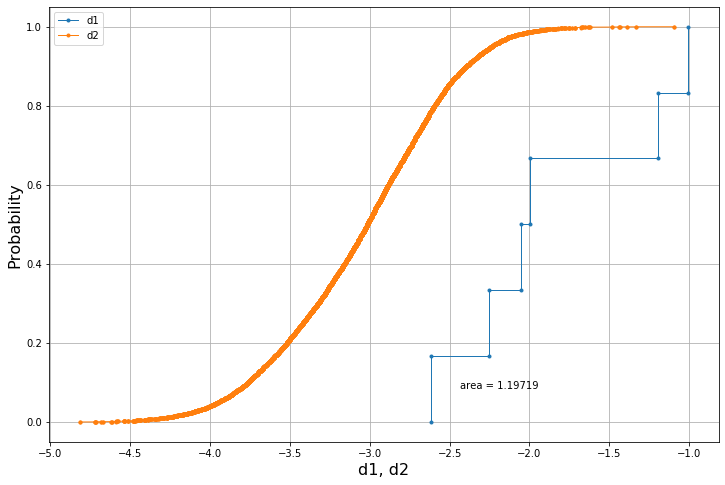

In [97]:
AM_final,LLH_final,CHISQ_final,plot = tests(df_10_1,GMM_A)

In [98]:
print(AM_final,LLH_final,CHISQ_final)

1.1971897038641006 11.317569182299875 15.840109819284956


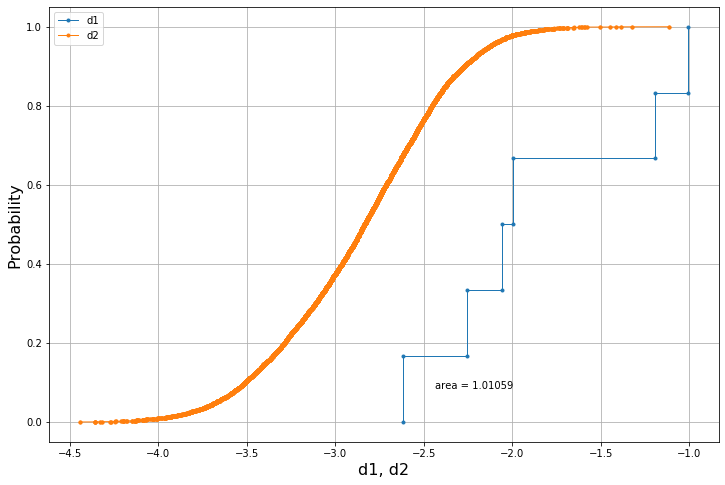

In [99]:
AM_final,LLH_final,CHISQ_final,plot = tests(df_10_1,GMM_B)

In [100]:
print(AM_final,LLH_final,CHISQ_final)

1.0105909907078112 11.410922744915402 16.228880983346382


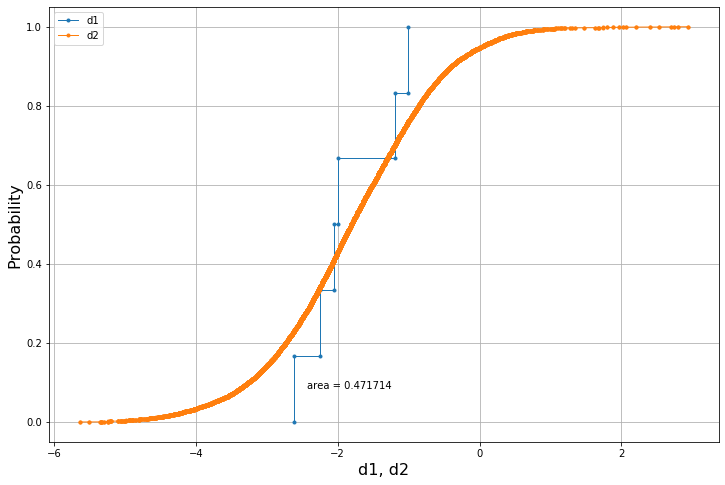

In [101]:
AM_final,LLH_final,CHISQ_final,plot = tests(df_10_1,GMM_D)

In [102]:
print(AM_final,LLH_final,CHISQ_final)

0.47171376883312255 1.7832866702903625 0.3599835125799829


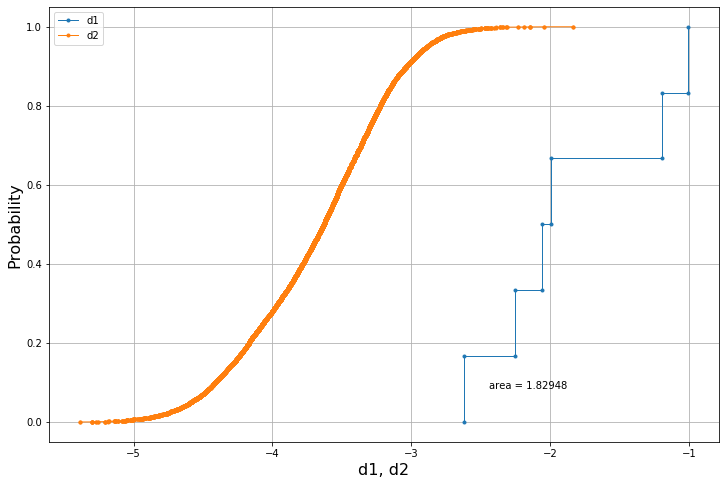

In [103]:
AM_final,LLH_final,CHISQ_final,plot = tests(df_10_1,GMM_R)

In [104]:
print(AM_final,LLH_final,CHISQ_final)

1.829480265438043 26.31471125904103 36.82930826081147
